In [1]:
%matplotlib inline
import pandas as pd

In [78]:
# 메타 데이터와 학습용 평점 정보 불러오기
metadata = pd.read_csv('metadata.csv')
ratings = pd.read_csv('ratings-train.csv')

In [79]:
# validation용 평점 정보 불러오기
# 데이터가 너무 크기 때문에 20%(frac = 0.2) 크기만 샘플링
# 학습하는 모두가 같은 샘플 데이터를 갖도록 random_state를 같은 값(17)으로 고정
ratings_valid = pd.read_csv('ratings-valid.csv').sample(random_state=17, frac=0.2)

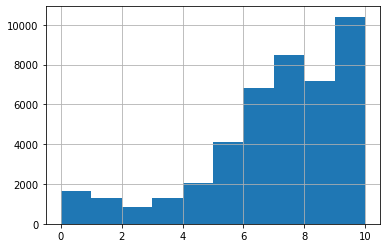

In [80]:
# 평점 정보의 분포 그려보기 (p. 20)
ratings['rating'].hist()

In [21]:
expected = ratings_valid[1:10]
answer = ratings_valid[:10]

In [28]:
# RMSE 계산하는 함수 만들기 (p. 23)
import numpy as np
def rmse(expected, answer):
    joined = pd.merge(answer, expected, on=['userid', 'itemid'], how='left')
    joined['rating_y'] = joined['rating_y'].fillna(0)
    joined['square_error'] = (joined['rating_x'] - joined['rating_y']) ** 2
    return np.sqrt(joined['square_error'].mean())

In [29]:
rmse(expected, answer)

2.8460498941515415

In [40]:
# 모든 예측을 8점으로 하는 추천 로직
def predict(u, i):
    return 8.0

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.7423239390279464

In [45]:
# 모든 예측을 전체 평점의 평균으로 계산하는 추천 로직 (p. 24)
r_mean = ratings['rating'].mean()
def predict(u, i):
    return r_mean

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.418031954051125

In [66]:
# 모든 예측을 주어진 사용자의 평균 평점으로 계산하는 추천 로직 (p. 25)
def predict(u, i):
    return ratings[ratings['userid'] == u]['rating'].mean()

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.1909154513519242

In [67]:
# 모든 예측을 주어진 영화의 평균 평점으로 계산하는 추천 로직 (p. 25)
def predict(u, i):
    return ratings[ratings['itemid'] == i]['rating'].mean()

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.237838086446809

In [75]:
# 서로 다른 사용자 u, v에 대해 jaccard similarity 계산하는 함수 (p. 28)
all_users = ratings['userid'].unique()
i_dict = {u: set(ratings[ratings['userid'] == u]['itemid']) for u in all_users}
def sim(u, v):
    # i_u = set(ratings[ratings['userid'] == u]['itemid'])
    # i_v = set(ratings[ratings['userid'] == v]['itemid'])
    i_u = i_dict[u]
    i_v = i_dict[v]
    
    cup = i_u | i_v
    if len(cup) == 0:
        return 0.0
    cap = i_u & i_v
    return len(cap) / len(cup)

In [76]:
sim('TERhUA==', 'Q1ladXM=')

0.08333333333333333

In [98]:
# 비슷한 영화를 소비한 k명의 사용자 집합 U_u를 계산하는 similar_users(u, k) 함수 (p. 29)
def similar_users(u, k):
    sims = sorted([(sim(u, v), v) for v in all_users if u != v], reverse=True)
    topk_users = [v for s, v in sims][:k]
    return pd.DataFrame(topk_users, columns=['userid'])

In [99]:
similar_users('TERhUA==', 5)

,userid
0,YzkyQQ==
1,NGdmcVQ=
2,M2hETGQ=
3,V0NyaQ==
4,QTB5d0E=


In [121]:
def predict(u, i):
    topk_users = similar_users(u, 5)
    topk_users['sim'] = topk_users.apply(lambda row: sim(u, row['userid']), axis=1)
    i_ratings = ratings[ratings['itemid'] == i]
    joined = pd.merge(topk_users, i_ratings, on='userid')
    joined['weighted_rating'] = joined['sim'] * joined['rating']
    return joined['weighted_rating'].sum() / joined['sim'].sum()

In [135]:
expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

7.127239311832895